In [ ]:
#|default_exp test

In [ ]:
#|export
from fastcore.imports import *
from collections import Counter
from contextlib import redirect_stdout

In [ ]:
#|hide
from nbdev.showdoc import *
from fastcore.nb_imports import *

# Test

> Helper functions to quickly write tests in notebooks

## Simple test functions

We can check that code raises an exception when that's expected (`test_fail`).

To test for equality or inequality (with different types of things) we define a simple function `test` that compares two objects with a given `cmp` operator.

In [ ]:
#|export
def test_fail(f, msg='', contains='', args=None, kwargs=None):
    "Fails with `msg` unless `f()` raises an exception and (optionally) has `contains` in `e.args`"
    args, kwargs = args or [], kwargs or {}
    try: f(*args, **kwargs)
    except Exception as e:
        assert not contains or contains in str(e)
        return
    assert False,f"Expected exception but none raised. {msg}"

In [ ]:
def _fail(): raise Exception("foobar")
test_fail(_fail, contains="foo")

def _fail(): raise Exception()
test_fail(_fail)

We can also pass `args` and `kwargs` to function to check if it fails with special inputs.

In [ ]:
def _fail_args(a):
    if a == 5:
        raise ValueError
test_fail(_fail_args, args=(5,))
test_fail(_fail_args, kwargs=dict(a=5))

In [ ]:
#|export
def test(a, b, cmp, cname=None):
    "`assert` that `cmp(a,b)`; display inputs and `cname or cmp.__name__` if it fails"
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

In [ ]:
test([1,2],[1,2], operator.eq)
test_fail(lambda: test([1,2],[1], operator.eq))
test([1,2],[1],   operator.ne)
test_fail(lambda: test([1,2],[1,2], operator.ne))

In [ ]:
show_doc(all_equal)

---

### all_equal

>      all_equal (a, b)

*Compares whether `a` and `b` are the same length and have the same contents*

In [ ]:
test(['abc'], ['abc'], all_equal)
test_fail(lambda: test(['abc'],['cab'], all_equal))

In [ ]:
show_doc(equals)

---

### equals

>      equals (a, b)

*Compares `a` and `b` for equality; supports sublists, tensors and arrays too*

In [ ]:
test([['abc'],['a']], [['abc'],['a']],  equals)
test([['abc'],['a'],'b', [['x']]], [['abc'],['a'],'b', [['x']]],  equals) # supports any depth and nested structure

In [ ]:
#|export
def nequals(a,b):
    "Compares `a` and `b` for `not equals`"
    return not equals(a,b)

In [ ]:
test(['abc'], ['ab' ], nequals)

## test_eq test_ne, etc...

Just use `test_eq`/`test_ne` to test for `==`/`!=`. `test_eq_type` checks things are equal and of the same type. We define them using `test`:

In [ ]:
#|export
def test_eq(a,b):
    "`test` that `a==b`"
    test(a,b,equals, cname='==')

In [ ]:
test_eq([1,2],[1,2])
test_eq([1,2],map(int,[1,2]))
test_eq(array([1,2]),array([1,2]))
test_eq(array([1,2]),array([1,2]))
test_eq([array([1,2]),3],[array([1,2]),3])
test_eq(dict(a=1,b=2), dict(b=2,a=1))
test_fail(lambda: test_eq([1,2], 1), contains="==")
test_fail(lambda: test_eq(None, np.array([1,2])), contains="==")
test_eq({'a', 'b', 'c'}, {'c', 'a', 'b'})

In [ ]:
#|hide
import pandas as pd
import torch

In [ ]:
df1 = pd.DataFrame(dict(a=[1,2],b=['a','b']))
df2 = pd.DataFrame(dict(a=[1,2],b=['a','b']))
df3 = pd.DataFrame(dict(a=[1,2],b=['a','c']))

test_eq(df1,df2)
test_eq(df1.a,df2.a)
test_fail(lambda: test_eq(df1,df3), contains='==')
class T(pd.Series): pass
test_eq(df1.iloc[0], T(df2.iloc[0])) # works with subclasses

In [ ]:
test_eq(torch.zeros(10), torch.zeros(10, dtype=torch.float64))
test_eq(torch.zeros(10), torch.ones(10)-1)
test_fail(lambda:test_eq(torch.zeros(10), torch.ones(1, 10)), contains='==')
test_eq(torch.zeros(3), [0,0,0])

In [ ]:
#|export
def test_eq_type(a,b):
    "`test` that `a==b` and are same type"
    test_eq(a,b)
    test_eq(type(a),type(b))
    if isinstance(a,(list,tuple)): test_eq(map(type,a),map(type,b))

In [ ]:
test_eq_type(1,1)
test_fail(lambda: test_eq_type(1,1.))
test_eq_type([1,1],[1,1])
test_fail(lambda: test_eq_type([1,1],(1,1)))
test_fail(lambda: test_eq_type([1,1],[1,1.]))

In [ ]:
#|export
def test_ne(a,b):
    "`test` that `a!=b`"
    test(a,b,nequals,'!=')

In [ ]:
test_ne([1,2],[1])
test_ne([1,2],[1,3])
test_ne(array([1,2]),array([1,1]))
test_ne(array([1,2]),array([1,1]))
test_ne([array([1,2]),3],[array([1,2])])
test_ne([3,4],array([3]))
test_ne([3,4],array([3,5]))
test_ne(dict(a=1,b=2), ['a', 'b'])
test_ne(['a', 'b'], dict(a=1,b=2))

In [ ]:
#|export
def is_close(a,b,eps=1e-5):
    "Is `a` within `eps` of `b`"
    if hasattr(a, '__array__') or hasattr(b,'__array__'):
        return (abs(a-b)<eps).all()
    if isinstance(a, (Iterable,Generator)) or isinstance(b, (Iterable,Generator)):
        return all(abs(a_-b_)<eps for a_,b_ in zip(a,b))
    return abs(a-b)<eps

In [ ]:
#|export
def test_close(a,b,eps=1e-5):
    "`test` that `a` is within `eps` of `b`"
    test(a,b,partial(is_close,eps=eps),'close')

In [ ]:
test_close(1,1.001,eps=1e-2)
test_fail(lambda: test_close(1,1.001))
test_close([-0.001,1.001], [0.,1.], eps=1e-2)
test_close(np.array([-0.001,1.001]), np.array([0.,1.]), eps=1e-2)
test_close(array([-0.001,1.001]), array([0.,1.]), eps=1e-2)

In [ ]:
#|export
def test_is(a,b):
    "`test` that `a is b`"
    test(a,b,operator.is_, 'is')

In [ ]:
test_fail(lambda: test_is([1], [1]))
a = [1]
test_is(a, a)
b = [2]; test_fail(lambda: test_is(a, b))

In [ ]:
#|export
def test_shuffled(a,b):
    "`test` that `a` and `b` are shuffled versions of the same sequence of items"
    test_ne(a, b)
    test_eq(Counter(a), Counter(b))

In [ ]:
a = list(range(50))
b = copy(a)
random.shuffle(b)
test_shuffled(a,b)
test_fail(lambda:test_shuffled(a,a))

In [ ]:
a = 'abc'
b = 'abcabc'
test_fail(lambda:test_shuffled(a,b))

In [ ]:
a = ['a', 42, True] 
b = [42, True, 'a']
test_shuffled(a,b)

In [ ]:
#|export
def test_stdout(f, exp, regex=False):
    "Test that `f` prints `exp` to stdout, optionally checking as `regex`"
    s = io.StringIO()
    with redirect_stdout(s): f()
    if regex: assert re.search(exp, s.getvalue()) is not None, f"regex '{exp}' did not not match stdout '{s.getvalue()}'"
    else: test_eq(s.getvalue(), f'{exp}\n' if len(exp) > 0 else '')

In [ ]:
test_stdout(lambda: print('hi'), 'hi')
test_fail(lambda: test_stdout(lambda: print('hi'), 'ho'))
test_stdout(lambda: 1+1, '')
test_stdout(lambda: print('hi there!'), r'^hi.*!$', regex=True)

In [ ]:
#|export
def test_warns(f, show=False):
    with warnings.catch_warnings(record=True) as w:
        f()
        assert w, "No warnings raised"
        if show:
            for e in w: print(f"{e.category}: {e.message}")

In [ ]:
test_warns(lambda: warnings.warn("Oh no!"))
test_fail(lambda: test_warns(lambda: 2+2), contains='No warnings raised')

In [ ]:
test_warns(lambda: warnings.warn("Oh no!"), show=True)

<class 'UserWarning'>: Oh no!


In [ ]:
#|export
TEST_IMAGE = 'images/puppy.jpg'

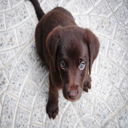

In [ ]:
im = Image.open(TEST_IMAGE).resize((128,128)); im

In [ ]:
#|export
TEST_IMAGE_BW = 'images/mnist3.png'

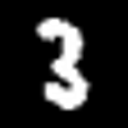

In [ ]:
im = Image.open(TEST_IMAGE_BW).resize((128,128)); im

In [ ]:
#|export
def test_fig_exists(ax):
    "Test there is a figure displayed in `ax`"
    if not hasattr(ax.figure.canvas, 'renderer'): ax.figure.canvas.draw()
    assert ax and len(ax.figure.canvas.tostring_argb())

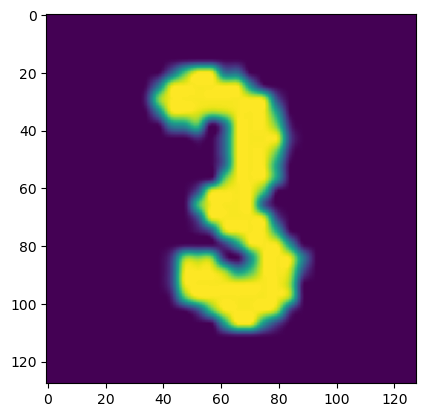

In [ ]:
fig,ax = plt.subplots()
ax.imshow(array(im));

In [ ]:
test_fig_exists(ax)

In [ ]:
#|export
class ExceptionExpected:
    "Context manager that tests if an exception is raised"
    def __init__(self, ex=Exception, regex=''): self.ex,self.regex = ex,regex
    def __enter__(self): pass
    def __exit__(self, type, value, traceback):
        if not isinstance(value, self.ex) or (self.regex and not re.search(self.regex, f'{value.args}')):
            raise TypeError(f"Expected {self.ex.__name__}({self.regex}) not raised.")
        return True

In [ ]:
def _tst_1(): assert False, "This is a test"
def _tst_2(): raise SyntaxError

with ExceptionExpected(): _tst_1()
with ExceptionExpected(ex=AssertionError, regex="This is a test"): _tst_1()
with ExceptionExpected(ex=SyntaxError): _tst_2()

`exception` is an abbreviation for `ExceptionExpected()`.

In [ ]:
#|export
exception = ExceptionExpected()

In [ ]:
with exception: _tst_1()

In [ ]:
#|hide
def _f():
    with ExceptionExpected(): 1
test_fail(partial(_f))

def _f():
    with ExceptionExpected(SyntaxError): assert False
test_fail(partial(_f))

def _f():
    with ExceptionExpected(AssertionError, "Yes"): assert False, "No"
test_fail(partial(_f))

## Export -

In [ ]:
#|hide
#|eval: false
from nbdev import nbdev_export
nbdev_export()

Converted 00_test.ipynb.
Converted 01_basics.ipynb.
Converted 02_foundation.ipynb.
Converted 03_xtras.ipynb.
Converted 03a_parallel.ipynb.
Converted 03b_net.ipynb.
Converted 04_dispatch.ipynb.
Converted 05_transform.ipynb.
Converted 07_meta.ipynb.
Converted 08_script.ipynb.
Converted index.ipynb.
